# ДЗ 3

- Студент: Алексей Ярошенко
- Email на портале: aleksey.yaroshenko@gmail.com
- https://docs.google.com/document/d/1KYoqG6dbfzcRCEXYWS1iKxQR9hZEHQUThW4moXWwvhk/edit

In [1]:
from datetime import timedelta, datetime
import pickle
import json
import gc
from copy import copy, deepcopy
from collections import defaultdict, Counter
import requests
import xmltodict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
from scipy import sparse
from scipy.special import expit as sigmoid
import scipy.stats as sts
from IPython.display import Image

## 1. Прочитайте и проанализируйте данные

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl)

In [101]:
raise AssertionError('Долго считается. Защита от случайного запуска :)')

with open('data/results.pkl', 'rb') as file:
    results = pickle.load(file)
    
with open('data/tournaments.pkl', 'rb') as file:
    tournaments = pickle.load(file)

date_train_start = datetime.strptime('2019-01-01', '%Y-%m-%d')
date_val_start = datetime.strptime('2020-01-01', '%Y-%m-%d')


tournaments_train = []
tournaments_val = []

max_player_id = 0
max_team_id = 0

for key in tqdm(tournaments.keys(), position=0, leave=False):
    tournament_date = datetime.fromisoformat(tournaments[key]['dateStart']).replace(tzinfo=None)
    if tournament_date >= date_train_start:
        
        # Если нет команд, пропускаем
        if not results[key]:
            continue

            
        total_questions = set()
        for team in results[key]:
            if team.get('mask') is not None:
                total_questions.add(len(team['mask']))
        
        # Пропустим турниры, где разное число вопросов
        if len(total_questions) > 1:
            continue
        tournament = dict()
        tournament['id'] = tournaments[key]['id']
        tournament['teams'] = []
        
        
        for team in results[key]:
            # Уберем команды, где нет ответов или в ответах есть 'X', '?'
            if team.get('mask') is None or team.get('mask').replace('1', '').replace('0', ''):
                continue
                
            if team['team']['id'] > max_team_id:
                max_team_id = team['team']['id']
            
            team_dict = dict()
            team_dict['id'] = team['team']['id']
            team_dict['mask'] = team['mask']
            team_dict['members'] = []
            
            for member in team['teamMembers']:
                
                player_id = member['player']['id']
                if player_id > max_player_id:
                    max_player_id = player_id
                    
                team_dict['members'].append(player_id)
                
            tournament['teams'].append(team_dict)
        
        if not tournament['teams']:
            continue
        
        # Сразу будем делить на трейн и валидацию
        if tournament_date < date_val_start:
            tournaments_train.append(tournament)
        else:
            tournaments_val.append(tournament)
            
# Сохраним нужное, чтобы потом быстро подгружать
with open('data/tournaments_train.json', 'w') as file:
    json.dump(tournaments_train, file)
    
with open('data/tournaments_val.json', 'w') as file:
    json.dump(tournaments_val, file)
    
del results, tournaments

gc.collect()

64

In [2]:
with open('data/tournaments_train.json', 'r') as file:
    tournaments_train = json.load(file)
    
with open('data/tournaments_val.json', 'r') as file:
    tournaments_val = json.load(file)
    
with open('data/players.pkl', 'rb') as file:
    players = pickle.load(file)

Среднее число вопросов: 47. Максимальное - 500.
В среднем один игрок играет в 6.22 командах. Самый главный перебежчик - в 184.


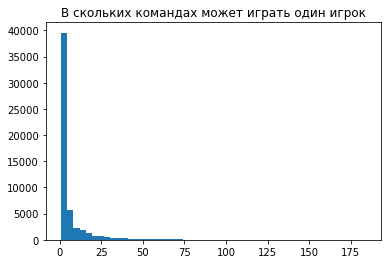

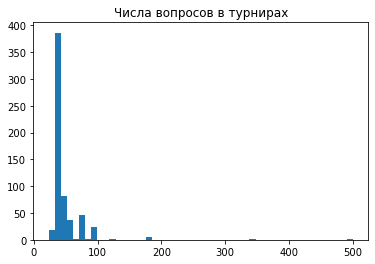

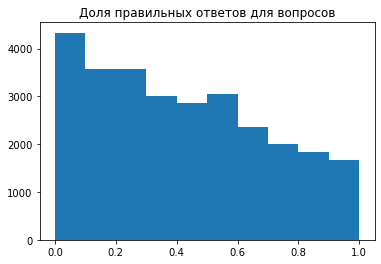

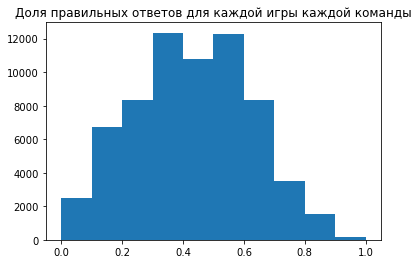

In [3]:
members = defaultdict(set)
correct_answers_raito = []
questions_counts = []
difficulty = []
questions_raito = []
team_count_for_member = []


for tournament in tournaments_train:
    tournament_answers = []
    for team in tournament['teams']:
        team_answers = list(map(int, team['mask']))
        questions_count = len(team_answers)
        correct_answers = sum(team_answers)
        correct_answers_raito.append(correct_answers / questions_count)
        tournament_answers.append(team_answers)
    

        
        for member in team['members']:
            members[member].add(tournament['id'])
    
    questions_counts.append(questions_count)  
    difficulty += (1 - np.array(tournament_answers).mean(axis=0)).tolist()
    questions_raito += np.array(tournament_answers).mean(axis=0).tolist()
    
for member, teams in members.items():
    team_count_for_member.append(len(teams))

    
print(f'Среднее число вопросов: {np.mean(questions_counts):.0f}. Максимальное - {np.max(questions_counts)}.')
print(f'В среднем один игрок играет в {np.mean(team_count_for_member):.2f} командах. Самый главный перебежчик - в {np.max(team_count_for_member)}.')



plt.hist(team_count_for_member, bins=50)
plt.title('В скольких командах может играть один игрок')
plt.show();

plt.hist(questions_counts, bins=50)

plt.title('Числа вопросов в турнирах')
plt.show();

plt.hist(questions_raito, bins=10)
plt.title('Доля правильных ответов для вопросов')
plt.show();

plt.hist(correct_answers_raito, bins=10)
plt.title('Доля правильных ответов для каждой игры каждой команды')
plt.show();

## 2. Baseline

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.

Построим словари id игрока -> индекс и обратный.

Всего игроков в обучающей выборке: 55151
Игроков с 1000+ ответами: 3245


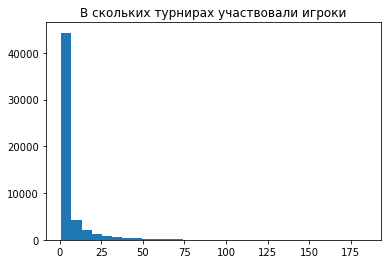

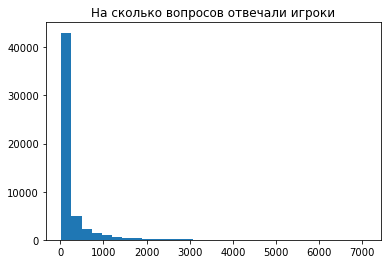

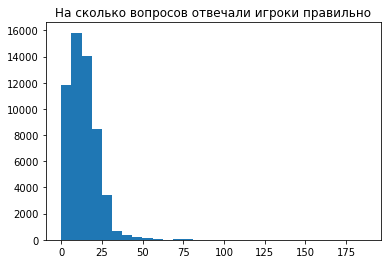

In [4]:
members = set()
member_answers = defaultdict(int)
member_right_answers = defaultdict(int)
member_tours = defaultdict(int)

for tournament in tournaments_train:
    tournament_answers = []
    for team in tournament['teams']:
        for member in team['members']:
            member_answers[member] += len(team['mask'])
            member_right_answers[member] = sum(list(map(int, team['mask'])))
            member_tours[member] += 1
            members.add(member)
        

member_to_idx = {member:idx for idx, member in enumerate(members)}
idx_to_members = {idx:member for member, idx in member_to_idx.items()}
member_1000 = [member for member, answers in member_answers.items() if answers > 1000]

print(f'Всего игроков в обучающей выборке: {len(member_to_idx)}')
print(f'Игроков с 1000+ ответами: {len(member_1000)}')

plt.hist(member_tours.values(), bins=30);
plt.title('В скольких турнирах участвовали игроки')
plt.show();

plt.hist(member_answers.values(), bins=30);
plt.title('На сколько вопросов отвечали игроки')
plt.show();

plt.hist(member_right_answers.values(), bins=30);
plt.title('На сколько вопросов отвечали игроки правильно')
plt.show();

Соберем обучающую выборку.

- Объект - 2 сконкатенированных onehot-вектора: вектор всех игроков + вектор всех вопросов.
- Таргет - ответил или нет игрок на вопрос.

Будем использовать sparse-матрицы, ибо обычные в память не влезут.

In [296]:
member_idxs = []
question_idxs = []
team_ids = []
tournament_ids = []
results = []
member_questions_count = []

questions_count = 0
for tournament in tournaments_train:
    tour_questions_count = len(tournament['teams'][0]['mask'])
    for team in tournament['teams']:
        team_answers = list(map(int, team['mask']))
        for q in range(tour_questions_count):
            for member in team['members']:
                member_idxs.append(member_to_idx[member])
                question_idxs.append(len(member_to_idx) + questions_count + q)
                team_ids.append(team['id'])
                tournament_ids.append(tournament['id'])
                results.append(team_answers[q])
                member_questions_count.append(member_answers[member])
    questions_count += tour_questions_count
    
    
X = sparse.lil_matrix((len(member_idxs), len(member_to_idx) + questions_count),  dtype=int)
X[range(len(member_idxs)), member_idxs] = 1
X[range(len(member_idxs)), question_idxs] = 1
y = np.array(results)

dim0, dim1 = X.shape # чтобы потом 
len(member_idxs), len(member_to_idx), questions_count

(13749583, 55151, 28264)

In [6]:
lr = LogisticRegression(tol=1e-1, solver='saga', C=10)

In [7]:
%%time
lr.fit(X, y)

CPU times: user 43.8 s, sys: 147 ms, total: 43.9 s
Wall time: 44 s


LogisticRegression(C=10, solver='saga', tol=0.1)

В качестве рейтинга возьмем коэфициенты логистической регрессии. Достанем рейтинг игроков и рейтинг вопросов.

In [10]:
question_rating = lr.coef_[0][len(member_to_idx):]
rating = lr.coef_[0][:len(member_to_idx)]
rating_list = []
for idx, member in idx_to_members.items():
    item = {
        'score': rating[idx],
        'id': member,
        'name': players[member]['name'] + ' ' + players[member]['surname'],
        'questions_count': member_answers[member],
    }
    rating_list.append(item)
    
sorted_rating = sorted(rating_list, key=lambda x: x['score'], reverse=True)

In [11]:
def get_member_position(id):
    url = f'https://rating.chgk.info/api/players/{id}/rating/last'
    position = -1
    try:
        position = requests.get(url).json()['rating_position']
        position = int(position)
    except Exception as e:
        pass
    
    return position

В принципе, получилось относительно адекватно и близко к реальному рейтингу.

In [12]:
df_rating = pd.DataFrame(sorted_rating)[:50]
df_rating['actual_position'] = df_rating['id'].apply(get_member_position)
df_rating['questions_count'] = df_rating['id'].apply(lambda x: member_answers[x])
df_rating.head(50)

,score,id,name,questions_count,actual_position
0,4.458247,27403,Максим Руссо,1796,5
1,4.345417,4270,Александра Брутер,2240,6
2,4.248463,28751,Иван Семушин,3071,4
3,4.232077,27822,Михаил Савченков,2666,3
4,4.126304,40411,Дмитрий Кудинов,45,-1
5,4.113925,30152,Артём Сорожкин,4006,1
6,4.113432,30270,Сергей Спешков,3017,2
7,4.049244,20691,Станислав Мереминский,1370,38
8,4.005399,22799,Сергей Николенко,1806,10
9,3.979493,38175,Максим Пилипенко,36,9888


In [13]:
top_50_count = df_rating[df_rating['actual_position'] <= 100].shape[0]

print(f'В топ-50 рейтинга модели попали {top_50_count} игроков из топ-100 реального рейтинга')

В топ-50 рейтинга модели попали 31 игроков из топ-100 реального рейтинга


Уберем игроков, которые сыграли меньше 1000 вопросов.

In [14]:
df_rating_1000 = pd.DataFrame(list(filter(lambda x: x['id'] in member_1000, sorted_rating)))[:50]
df_rating_1000['actual_position'] = df_rating_1000['id'].apply(get_member_position)
df_rating_1000['questions_count'] = df_rating_1000['id'].apply(lambda x: member_answers[x])
df_rating_1000.head(50)

,score,id,name,questions_count,actual_position
0,4.458247,27403,Максим Руссо,1796,5
1,4.345417,4270,Александра Брутер,2240,6
2,4.248463,28751,Иван Семушин,3071,4
3,4.232077,27822,Михаил Савченков,2666,3
4,4.113925,30152,Артём Сорожкин,4006,1
5,4.113432,30270,Сергей Спешков,3017,2
6,4.049244,20691,Станислав Мереминский,1370,38
7,4.005399,22799,Сергей Николенко,1806,10
8,3.953536,18036,Михаил Левандовский,1113,8
9,3.911088,22935,Илья Новиков,1266,132


In [15]:
top_50_count = df_rating_1000[df_rating_1000['actual_position'] <= 100].shape[0]

print(f'В топ-50 рейтинга модели попали {top_50_count} игроков из топ-100 реального рейтинга')

В топ-50 рейтинга модели попали 40 игроков из топ-100 реального рейтинга


## 3. Оценка качества

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:

- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;

- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


Уберем из тестовой выборки новых участников, о которых у нас нет данных в обучающей выборке. Заодно, сразу и посчитаем число правильных ответов в командах.

In [16]:
tournaments_test = []
tournaments_rating_true = []

for tournament in tournaments_val:
    teams_test = []
    teams_rating = []
    for team in tournament['teams']:
  
        memebers = [member for member in team['members'] if member in member_to_idx.keys()]
        team_test = copy(team)
        team_test['members'] = memebers
        
        if len(memebers) > 0:
            teams_test.append(team_test)
            team_answers = list(map(int, team['mask']))
            team_score = sum(team_answers)
            teams_rating.append(team_score)
     
    if len(teams_test) > 1:
        tournament_test = copy(tournament)
        tournament_test['teams'] = teams_test
        tournaments_test.append(tournament_test)
        tournaments_rating_true.append(teams_rating)

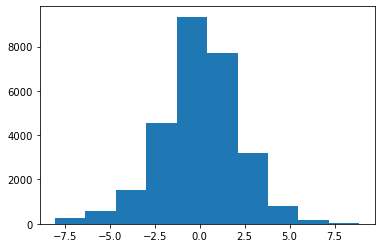

In [17]:
plt.hist(question_rating);

В качестве рейтинга команды будем использовать вероятность того, что 1 или более игроков команды ответили на вопрос правильно: $P(team=1) = 1 - \prod P(member=0)$

Т.к. вопросы у нас неизвестны и важны не абсолютные значения числа отвеченных вопросов, то наша задача - сравнить "силу" команд. Для этого возьмем 1 вопрос. Т.к. коэфициенты, которые мы обучили для вопросов, распределены вокруг нуля, возьмем вопрос с коэффициентом 0. Для этого нам вообще ничего не нужно делать.

In [18]:
def predict_tournaments(model, tournaments, member_to_idx):

    tournaments_rating_pred = []
    for torunament in tqdm(tournaments, position=0, leave=False):
        tournament_questions_count = len(tournament['teams'][0]['mask'])
        preds = []
        for team in torunament['teams']:
            memeber_idxs = [member_to_idx[member] for member in team['members']]
            members_count = len(memeber_idxs)
 
            X = sparse.lil_matrix((members_count, dim1), dtype=int)
            X[range(len(memeber_idxs)), memeber_idxs] = 1
        
            fail_probas = model.predict_proba(X)[:, 0]
            team_proba = 1 - fail_probas.prod() 
            preds.append(team_proba)

        tournaments_rating_pred.append(preds)
    return tournaments_rating_pred

def print_correlations(tournaments_rating_true, tournaments_rating_pred):

    spearmanr_corrs = []
    kendall_corrs = []
    for i in range(len(tournaments_rating_true)):
        spearman = sts.spearmanr(tournaments_rating_true[i], tournaments_rating_pred[i]).correlation
        kendall = sts.kendalltau(tournaments_rating_true[i], tournaments_rating_pred[i]).correlation
        spearmanr_corrs.append(spearman)
        kendall_corrs.append(kendall)

    print(f'Корреляция Спирмена: {np.mean(spearmanr_corrs):.4f}')
    print(f'Корреляция Кендалла: {np.mean(kendall_corrs):.4f}')

In [19]:

tournaments_rating_pred = predict_tournaments(
    model=lr, 
    tournaments=tournaments_test,
    member_to_idx=member_to_idx, 
)
assert len(tournaments_rating_pred) == len(tournaments_rating_true)

print_correlations(tournaments_rating_true, tournaments_rating_pred)

Корреляция Спирмена: 0.8045
Корреляция Кендалла: 0.6465


## 4. EM-алгоритм

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:

- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


В качестве вектора скрытых переменных будем использовать вероятность ответа игроком на вопрос при условии команды: $z = P(member=1|team)$

Сделаем предположение, что если команда не ответила на вопрос, то никто в команде не ответил на вопрос (на самом деле, ответ мог прозвучать, но его не приняли участники). Т.е. $P(member=1|team=0) = 0$

- E-шаг: предсказываем вероятности ответа на вопрос игрока при условии команды: 
$P(member=1|team=1) = \frac{P(member=1 \cap team=1)}{P(team=1)} = \frac{P(team=1 | member=1) P(member=1)}{P(team=1)} = \frac{P(member=1)}{P(team=1)}$
- M-шаг: максимизируем правдоподобие. Обучаем модель на вероятностях с E-шага

За начальное приближение возьмем $z$ возьмем ответы каждого игрока команды, как будте он играет независимо (как в baseline). Обучим логистическую регрессиию, будем использовать ее веса как точку старта. Это просто быстрее.

In [20]:
lr_initial = LogisticRegression(tol=1e-1, solver='saga', penalty='none')
lr_initial.fit(X, y)

Здесь понадобится немного модифицированная логистическая регрессия. Обычная из sklearn принимает метки класса, а нужно, чтобы логистическая регрессия принимала вероятности на вход. Будем обучать стохастическим градиентным спуском по батчам.

In [252]:
class ProbabilityEstimator:
    def __init__(self, init_classifier=None):
        if init_classifier:
            self.w = np.hstack((init_classifier.intercept_, init_classifier.coef_[0]))
        else:
            self.w = None
        
    def fit(self, X, y, max_iters=100000, lr=10, batch_size=1000, tol=0.0000001):
        X = sparse.hstack([np.ones(len(y)).reshape(-1, 1), X], format='csr')
        if self.w is None:
            self.w = np.random.normal(size=X.shape[1])
            
        losses = []
        prev_mean_loss = np.inf
        
        data_len = X.shape[0]
        
        for i in range(max_iters):
            batch_idxs = np.random.choice(data_len, batch_size)
            X_batch = X[batch_idxs, :]
            y_batch = y[batch_idxs]
            preds = sigmoid(X_batch.dot(self.w))
            losses.append(self.log_loss(y_batch, preds))
            if (i + 1) % 1000 == 0:
                new_mean_loss = np.mean(losses)
                if (prev_mean_loss - new_mean_loss) < tol:
                    print(f'Fitted. Mean NLL: {new_mean_loss}', flush=True)
                    break                    
                losses = []
                prev_mean_loss = new_mean_loss

            grad = -X_batch.T.dot(y_batch - preds) / len(y_batch)
            self.w -= lr * grad 
    
    def predict_proba(self, X):
        X = sparse.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
        preds = sigmoid(X.dot(self.w))
        return np.hstack(((1 - preds).reshape(-1, 1), preds.reshape(-1, 1)))
    
    @staticmethod
    def log_loss(y, p):
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [285]:
estimator = ProbabilityEstimator(init_classifier=lr_initial)

tournaments_rating_pred = predict_tournaments(
    model=estimator, 
    tournaments=tournaments_test,
    member_to_idx=member_to_idx, 
)
print_correlations(tournaments_rating_true, tournaments_rating_pred)

for _ in range(15):
    
    # E-шаг
    preds = estimator.predict_proba(X)
    
    # Вероятность ответа игрока при условии команды
    df_team = pd.DataFrame({'team': team_ids, 'question': question_idxs, 'fail_pred': preds[:, 0], 'success_pred': preds[:, 1]})
    df_team_pis = df_team.groupby(['team', 'question']).agg({'fail_pred': 'prod'}).reset_index()
    df_team_pis['team_success_pred'] = 1 - df_team_pis['fail_pred']
    df_team_pis.drop(columns=['fail_pred'], inplace=True)
    df_team = pd.merge(df_team, df_team_pis, left_on=['team', 'question'],  right_on=['team', 'question'])
    z = (df_team['success_pred'] / df_team['team_success_pred']).clip(0, 1)
    
    # По нашему предположению, мы уверены, что если команда не ответила на вопрос, 
    # то никто из команды на него не ответил
    z[y == 0] = 0
    
    
    # M-шаг
    estimator.fit(X, z, lr=20)

    tournaments_rating_pred = predict_tournaments(
        model=estimator, 
        tournaments=tournaments_test,
        member_to_idx=member_to_idx, 
    )
    print_correlations(tournaments_rating_true, tournaments_rating_pred)
    




Корреляция Спирмена: 0.8044
Корреляция Кендалла: 0.6460
Fitted. Mean NLL: 0.5215590512803685


Корреляция Спирмена: 0.8155
Корреляция Кендалла: 0.6597
Fitted. Mean NLL: 0.2943799853426044


Корреляция Спирмена: 0.8191
Корреляция Кендалла: 0.6625
Fitted. Mean NLL: 0.30811460736307095


Корреляция Спирмена: 0.8193
Корреляция Кендалла: 0.6632
Fitted. Mean NLL: 0.3116687319331091


Корреляция Спирмена: 0.8192
Корреляция Кендалла: 0.6625
Fitted. Mean NLL: 0.3100833960592953


Корреляция Спирмена: 0.8202
Корреляция Кендалла: 0.6639
Fitted. Mean NLL: 0.30947342979693854


Корреляция Спирмена: 0.8191
Корреляция Кендалла: 0.6623
Fitted. Mean NLL: 0.3112445922089581


Корреляция Спирмена: 0.8194
Корреляция Кендалла: 0.6628
Fitted. Mean NLL: 0.31489490677850385


Корреляция Спирмена: 0.8195
Корреляция Кендалла: 0.6627
Fitted. Mean NLL: 0.3154454628865559


Корреляция Спирмена: 0.8193
Корреляция Кендалла: 0.6627
Fitted. Mean NLL: 0.3168537118053495


Корреляция Спирмена: 0.8195
Корреляция Кендалла: 0.6628
Fitted. Mean NLL: 0.3057882812162128


Корреляция Спирмена: 0.8191
Корреляция Кендалла: 0.6621
Fitted. Mean NLL: 0.30683541809752535


Корреляция Спирмена: 0.8198
Корреляция Кендалла: 0.6629
Fitted. Mean NLL: 0.3097350247704601


Корреляция Спирмена: 0.8192
Корреляция Кендалла: 0.6631
Fitted. Mean NLL: 0.3067887606145755


Корреляция Спирмена: 0.8193
Корреляция Кендалла: 0.6625
Fitted. Mean NLL: 0.31150971503352104


Корреляция Спирмена: 0.8232
Корреляция Кендалла: 0.6682


Метрики действительно выросли. Посмотрим на новый рейтинг игроков.

In [288]:
question_rating = estimator.w[len(member_to_idx) + 1:]
rating = estimator.w[1:len(member_to_idx) + 1]
rating_list = []
for idx, member in idx_to_members.items():
    item = {
        'score': rating[idx],
        'id': member,
        'name': players[member]['name'] + ' ' + players[member]['surname'],
        'questions_count': member_answers[member],
    }
    rating_list.append(item)
    
sorted_rating = sorted(rating_list, key=lambda x: x['score'], reverse=True)

In [289]:
df_rating_em = pd.DataFrame(sorted_rating)[:50]
df_rating_em['actual_position'] = df_rating_em['id'].apply(get_member_position)
df_rating_em['questions_count'] = df_rating_em['id'].apply(lambda x: member_answers[x])
df_rating_em.head(50)

,score,id,name,questions_count,actual_position
0,4.607092,22474,Илья Немец,75,4479
1,4.431149,15727,Александр Коробейников,1175,110
2,4.404811,74001,Игорь Мокин,900,74
3,4.381209,40411,Дмитрий Кудинов,45,-1
4,4.368454,30260,Евгений Спектор,233,1585
5,4.343986,38175,Максим Пилипенко,36,9888
6,4.308858,34328,Михаил Царёв,366,310
7,4.268688,210174,Анна Карпелевич,60,16451
8,4.226258,4063,Дмитрий Борок,624,352
9,4.221897,21698,Александр Мосягин,838,146


In [291]:
top_50_count = df_rating_em[df_rating_em['actual_position'] <= 50].shape[0]

print(f'В топ-50 рейтинга модели попали {top_50_count} игроков из топ-50 реального рейтинга')

В топ-50 рейтинга модели попали 15 игроков из топ-50 реального рейтинга


In [292]:
THRESHOLD = 1000
print(f"В baseline модели в топ-50 было {(df_rating['questions_count'] < THRESHOLD).sum()} игроков, сыгравших меньше {THRESHOLD} вопросов, в EM-модели - {(df_rating_em['questions_count'] < THRESHOLD).sum()}")

В baseline модели в топ-50 было 20 игроков, сыгравших меньше 1000 вопросов, в EM-модели - 29


Noname игроков стало действительно больше.

## 5. Рейтинг турниров по сложности вопросов

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).


Посчитаем среднюю сложность вопросов в турнире. Для этого возьмем коэффициенты нашей модели, связанные с вопросами. Самый сложный вопрос - самый маленький коэффициент.

In [293]:
with open('data/tournaments.pkl', 'rb') as file:
    tournaments = pickle.load(file)

tournament_rating = dict()
question_rating = estimator.w[1 + len(member_to_idx):]
question_to_tour = dict()

questions_count = 0
for tournament in tournaments_train:
    tour_questions_count = len(tournament['teams'][0]['mask'])
    start_index, end_index = questions_count, questions_count + tour_questions_count
    tournament_rating[tournament['id']] = np.mean(question_rating[start_index: end_index])
    
    for q in range(tour_questions_count):
        question_to_tour[questions_count + q] = {
            'tournament_id': tournament['id'],
            'tournament_name': tournaments[tournament['id']]['name'],
            'question_num': q + 1,
        }
    questions_count += tour_questions_count
    
tournament_rating = sorted(tournament_rating.items(), key=lambda x: x[1])
df_tournament_rating = pd.DataFrame(tournament_rating, columns=['id', 'rating']).drop(columns=['rating'])
df_tournament_rating['name'] = df_tournament_rating['id'].apply(lambda x: tournaments[x]['name'])

Топ-20 турниров с самыми сложными вопросами по версии модели

In [294]:
df_tournament_rating.head(20)

,id,name
0,6149,Чемпионат Санкт-Петербурга. Первая лига
1,6101,Воображаемый музей
2,5928,Угрюмый Ёрш
3,5930,Зеркало мемориала памяти Михаила Басса
4,5159,Первенство правого полушария
5,5943,Чемпионат Мира. Этап 2 Группа С
6,5427,День D
7,5587,Записки охотника
8,5929,Мемориал памяти Михаила Басса
9,5947,Чемпионат Мира. Этап 3. Группа С


Топ-20 турниров с самыми простыми вопросами по версии модели

In [295]:
df_tournament_rating[::-1].head(20)

,id,name
603,5955,Школьная лига. III тур.
602,5936,Школьная лига. I тур.
601,5954,Школьная лига. II тур.
600,5012,Школьный Синхрон-lite. Выпуск 2.5
599,5013,(а)Синхрон-lite. Лига старта. Эпизод V
598,5457,Студенческий чемпионат Калининградской области
597,5697,Школьный Синхрон-lite. Выпуск 3.1
596,5701,Школьный Синхрон-lite. Выпуск 3.3
595,5698,(а)Синхрон-lite. Лига старта. Эпизод VII
594,5008,Школьный Синхрон-lite. Выпуск 2.3


В принципе, все логично и сходится со здравым смыслом.

## 6. Рейтинг игроков и число вопросов

Бонус: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в официальном рейтинге ЧГК, вы увидите, что это какие-то непонятные ноунеймы. В baseline-модели, скорее всего, такой эффект будет гораздо слабее.

Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить.

**1) Cначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;**

Выберем отсечку в 1000 вопросов, потому что в топе люди в основном с сыгранными 30+ турнирами за год.

In [302]:
df_rating_em_1000 = pd.DataFrame(list(filter(lambda x: member_answers[x['id']] > 1000, sorted_rating)))[:50]
df_rating_em_1000['actual_position'] = df_rating_em_1000['id'].apply(get_member_position)
df_rating_em_1000['questions_count'] = df_rating_em_1000['id'].apply(lambda x: member_answers[x])
df_rating_em_1000.head(50)

,score,id,name,questions_count,actual_position
0,4.431149,15727,Александр Коробейников,1175,110
1,4.179825,30152,Артём Сорожкин,4006,1
2,4.148237,27403,Максим Руссо,1796,5
3,4.147369,7008,Алексей Гилёв,3493,30
4,4.101212,28751,Иван Семушин,3071,4
5,4.073391,20691,Станислав Мереминский,1370,38
6,4.005153,22935,Илья Новиков,1266,132
7,3.975309,27822,Михаил Савченков,2666,3
8,3.919568,24384,Евгений Пашковский,1224,115
9,3.888037,16837,Наталья Кудряшова,2147,23


**2) можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;**

Судя по вопросу, так делать не стоит :) Но я пока не вижу никаких подводных камней кроме того, что у нас может появиться много "пустых" команд.

Попробуем вместо выкидываний игроков с малым числом вопросов, пометить их как те, кто не ответил ни на один вопрос.

In [303]:
y_threshold = y.copy()
y_threshold[np.array(member_questions_count) < 1000] = 0

Обучим новую инициализацию. Это нужно всего лишь для того, чтобы алгоритм сходился быстрее.

In [304]:
lr_initial_threshold = LogisticRegression(tol=1e-1, solver='saga', penalty='none')
lr_initial_threshold.fit(X, y_threshold)

LogisticRegression(penalty='none', solver='saga', tol=0.1)

In [311]:
estimator_threshold = ProbabilityEstimator(init_classifier=lr_initial_threshold)

tournaments_rating_pred = predict_tournaments(
    model=estimator_threshold, 
    tournaments=tournaments_test,
    member_to_idx=member_to_idx, 
)
print_correlations(tournaments_rating_true, tournaments_rating_pred)

for _ in range(3):
    
    # E-шаг
    preds = estimator_threshold.predict_proba(X)
    
    # Вероятность ответа игрока при условии команды
    df_team = pd.DataFrame({'team': team_ids, 'question': question_idxs, 'fail_pred': preds[:, 0], 'success_pred': preds[:, 1]})
    df_team_pis = df_team.groupby(['team', 'question']).agg({'fail_pred': 'prod'}).reset_index()
    df_team_pis['team_success_pred'] = 1 - df_team_pis['fail_pred']
    df_team_pis.drop(columns=['fail_pred'], inplace=True)
    df_team = pd.merge(df_team, df_team_pis, left_on=['team', 'question'],  right_on=['team', 'question'])
    z = (df_team['success_pred'] / df_team['team_success_pred']).clip(0, 1)
    
    # По нашему предположению, мы уверены, что если команда не ответила на вопрос, 
    # то никто из команды на него не ответил
    z[y_threshold == 0] = 0
    
    
    # M-шаг
    estimator_threshold.fit(X, z, lr=20)

    tournaments_rating_pred = predict_tournaments(
        model=estimator_threshold, 
        tournaments=tournaments_test,
        member_to_idx=member_to_idx, 
    )
    print_correlations(tournaments_rating_true, tournaments_rating_pred)

Корреляция Спирмена: 0.5676
Корреляция Кендалла: 0.4332
Fitted. Mean NLL: 0.17680002268947773


Корреляция Спирмена: 0.5771
Корреляция Кендалла: 0.4433
Fitted. Mean NLL: 0.17186749359476527


Корреляция Спирмена: 0.5813
Корреляция Кендалла: 0.4478
Fitted. Mean NLL: 0.1681100163106164


Корреляция Спирмена: 0.5847
Корреляция Кендалла: 0.4521


In [315]:
rating = estimator_threshold.w[1:len(member_to_idx) + 1]
rating_list = []
for idx, member in idx_to_members.items():
    item = {
        'score': rating[idx],
        'id': member,
        'name': players[member]['name'] + ' ' + players[member]['surname'],
        'questions_count': member_answers[member],
    }
    rating_list.append(item)
    
sorted_rating = sorted(rating_list, key=lambda x: x['score'], reverse=True)

In [316]:
df_rating_em_threshold = pd.DataFrame(sorted_rating)[:50]
df_rating_em_threshold['actual_position'] = df_rating_em_threshold['id'].apply(get_member_position)
df_rating_em_threshold['questions_count'] = df_rating_em_threshold['id'].apply(lambda x: member_answers[x])
df_rating_em_threshold.head(50)

,score,id,name,questions_count,actual_position
0,14.533894,27403,Максим Руссо,1796,5
1,14.396355,20001,Александр Мартынов,1254,49
2,14.381732,27822,Михаил Савченков,2666,3
3,14.365789,28751,Иван Семушин,3071,4
4,14.335055,4270,Александра Брутер,2240,6
5,14.169264,20691,Станислав Мереминский,1370,38
6,14.167084,30152,Артём Сорожкин,4006,1
7,14.154042,30270,Сергей Спешков,3017,2
8,14.106690,7008,Алексей Гилёв,3493,30
9,14.048845,22935,Илья Новиков,1266,132


Вроде, получилось адекватно. А те, кто сыграл мало игр - просто в самом низу рейтинга.

**3) предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).**

Я бы предложил добавить априорное знание о том, что у игрока высоко в рейтинге обычно много вопросов, как регуляризатор модели.

In [444]:
class ProbabilityEstimatorWithQuestionRegularization:
    def __init__(self, init_classifier=None):
        if init_classifier:
            self.w = np.hstack((init_classifier.intercept_, init_classifier.coef_[0]))
        else:
            self.w = None
        
    def fit(self, X, y, questions, questions_regularization=0.05, max_iters=100000, lr=10, batch_size=1000, tol=0.0000001):
        X = sparse.hstack([np.ones(len(y)).reshape(-1, 1), X], format='csr')
        questions = np.hstack(([0], np.array(questions), np.zeros(X.shape[1] - (len(questions) + 1))))
        questions = questions / np.max(questions)
        if self.w is None:
            self.w = np.random.normal(size=X.shape[1])
            
        losses = []
        prev_mean_loss = np.inf
        
        data_len = X.shape[0]
        
        for i in range(max_iters):
            batch_idxs = np.random.choice(data_len, batch_size)
            X_batch = X[batch_idxs, :]
            y_batch = y[batch_idxs]
            preds = sigmoid(X_batch.dot(self.w))
            losses.append(self.log_loss(y_batch, preds))
            if (i + 1) % 1000 == 0:
                new_mean_loss = np.mean(losses)
                print(f'Loss: {new_mean_loss}')
                if (prev_mean_loss - new_mean_loss) < tol:
                    print(f'Fitted. Mean NLL: {new_mean_loss}', flush=True)
                    break                    
                losses = []
                prev_mean_loss = new_mean_loss
                
            
            
            questions_reg = -questions_regularization * questions/len(y_batch)
            grad = -X_batch.T.dot(y_batch - preds) / len(y_batch) + questions_reg
            self.w -= lr * grad 
    
    def predict_proba(self, X):
        X = sparse.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
        preds = sigmoid(X.dot(self.w))
        return np.hstack(((1 - preds).reshape(-1, 1), preds.reshape(-1, 1)))
    
    @staticmethod
    def log_loss(y, p):
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [445]:
esimator_question_regularization = ProbabilityEstimatorWithQuestionRegularization()

In [446]:
questions = [member_answers[member] for member, idx in member_to_idx.items()]
esimator_question_regularization.fit(X, y, questions=questions, questions_regularization=0.05)

Loss: 0.8315135826673856
Loss: 0.745974206836949
Loss: 0.6986147965798527
Loss: 0.6631884623782184
Loss: 0.6395090508100144
Loss: 0.6208555892942393
Loss: 0.6064660669122065
Loss: 0.5930434904666104
Loss: 0.5834629472193417
Loss: 0.5764657474918689
Loss: 0.5688707076136061
Loss: 0.5625157364868447
Loss: 0.5578384733886348
Loss: 0.5527514325727483
Loss: 0.54808329007893
Loss: 0.5453693202470562
Loss: 0.5416951524948375
Loss: 0.53778983116771
Loss: 0.5371641482908992
Loss: 0.5331483959563396
Loss: 0.5322023181426558
Loss: 0.5304984790801096
Loss: 0.5295323271014606
Loss: 0.5274941782268235
Loss: 0.5262897069545156
Loss: 0.523795552648905
Loss: 0.5231925499825277
Loss: 0.521703280408582
Loss: 0.5200703071136943
Loss: 0.5187291676175079
Loss: 0.5184746124112016
Loss: 0.517979145031441
Loss: 0.5161516318297289
Loss: 0.5156009283685576
Loss: 0.5149228941929251
Loss: 0.5150336461298689
Fitted. Mean NLL: 0.5150336461298689


In [447]:
rating = esimator_question_regularization.w[1:len(member_to_idx) + 1]
rating_list = []
for idx, member in idx_to_members.items():
    item = {
        'score': rating[idx],
        'id': member,
        'name': players[member]['name'] + ' ' + players[member]['surname'],
        'questions_count': member_answers[member],
    }
    rating_list.append(item)
    
sorted_rating = sorted(rating_list, key=lambda x: x['score'], reverse=True)

In [448]:
df_rating_em_reg = pd.DataFrame(sorted_rating)[:50]
df_rating_em_reg['actual_position'] = df_rating_em_reg['id'].apply(get_member_position)
df_rating_em_reg['questions_count'] = df_rating_em_reg['id'].apply(lambda x: member_answers[x])
df_rating_em_reg.head(50)

,score,id,name,questions_count,actual_position
0,5.301652,30152,Артём Сорожкин,4006,1
1,5.247236,4270,Александра Брутер,2240,6
2,5.240978,28751,Иван Семушин,3071,4
3,5.211677,27403,Максим Руссо,1796,5
4,5.158775,30270,Сергей Спешков,3017,2
5,5.117235,27822,Михаил Савченков,2666,3
6,4.836993,7008,Алексей Гилёв,3493,30
7,4.814248,18332,Александр Либер,2937,7
8,4.738241,56647,Наталья Горелова,1769,349
9,4.666459,19915,Александр Марков,2473,51


Из плюсов:

- Топ модели относительно близок к реальному топу.
- Топ получился с игроками, которые сыграли много вопросов и без какой-то жесткой отсечки. 
- Силу влияния числа вопросов можно контролировать с помощью отдельного коэффициента регуляризации.

Из минусов:

- Придется подбирать правильный коэффициент регуляризации вопросов. Иначе либо с одной стороны можно получить хороший рейтинг за "стаж" (что в принципе не так и плохо, наверное). Либо с другой стороны в топ могут попасть игроки, которые сыграли мало игр но очень хорошо.

Как можно было бы улучшить:

- Думаю, можно было бы добавить нелинейность в число вопросов, чтобы совсем мало вопросов было очень плохо для рейтинга, но это влияние плавно снижалось.
- Добавить жесткую отсечку для игроков с 1-2-3 играми чтобы исключить тех, кому просто повезло.

## 7. Зависимость рейтинга от прошлого


Бонус: игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь возможность меняться даже у игроков, отыгравших сотни турниров. Давайте попробуем этого добиться:

- если хватит вычислительных ресурсов, сначала сделайте baseline совсем без таких схем, обучив рейтинги на всех турнирах с повопросными результатами, а не только на турнирах 2019 года; улучшилось ли качество предсказаний на 2020?
- одну схему со временем мы уже использовали: брали для обучения только последний год турниров; примерно так делают, например, в теннисной чемпионской гонке; у этой схемы есть свои преимущества, но есть и недостатки (например, достаточно мало играть год, чтобы полностью пропасть из рейтинга);
- предложите варианты базовой модели или алгоритма её обучения, которые могли бы реализовать изменения рейтинга со временем; если получится, реализуйте их на практике, проверьте, улучшатся ли предсказания на 2020.


К сожалению, вычислительных ресурсов не хватает. Я честно пытался :)

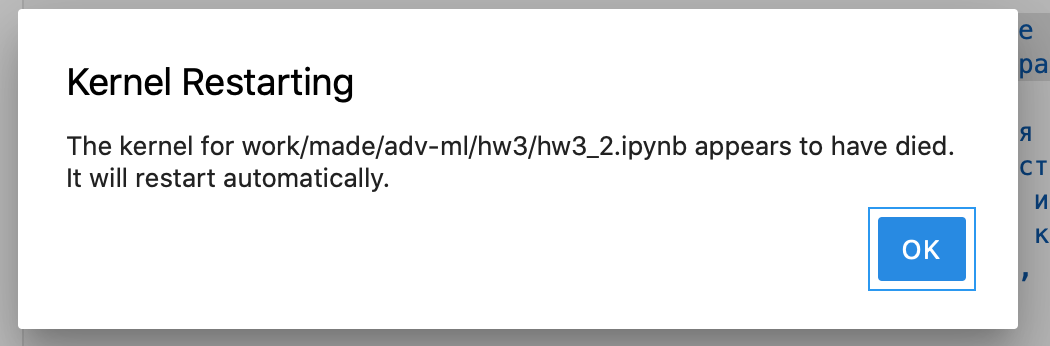

In [2]:
Image(filename='kernel_died.png')

Поэтому, просто опишу идею.

Я бы попробовал взвешивать объекты обучающей выборки в зависимости от от того, сколько дней прошло с даты турнира до текущей даты так, чтобы новые объекты получали бы больший вес и больше влияли на рейтинг.

### Вместо выводов

- Действительно, EM-алгоритм - это далеко не только про кластеризацию
- В реальных данных и реальной задаче намного больше нюансов, чем в каком-нибудь учебном датасете

Это было довольно сложно и интересно, спасибо!